In [32]:
from qutip import basis, sigmax, sigmaz, sigmay, tensor, qeye, sesolve
import matplotlib.pyplot as plt
import numpy as np

In [33]:
# Constants

OMEGA_11 = 400_000
OMEGA_12 = 400_000

J = 200

TAU_12 = np.pi / (2 * OMEGA_12)
TAU_J = np.pi / J
TAU_11 = np.pi / (2 * OMEGA_11)

STEP = 500

# Base states and operators definition

spin_up = basis(2, 0)
spin_down = basis(2, 1)

sx = sigmax()
sy = sigmay()
sz = sigmaz()

id = qeye(2)

state_00 = tensor(spin_up, spin_up)
state_01 = tensor(spin_up, spin_down)
state_10 = tensor(spin_down, spin_up)
state_11 = tensor(spin_down, spin_down)

# Initial condition of the system

psi_0 = state_11

In [34]:
def get_time_intervals():
    delta_t = [TAU_12, TAU_J, TAU_12, TAU_12, TAU_12, TAU_12, TAU_11, TAU_11, TAU_11]

    ti = 0
    t = []
    for times in delta_t:
        tf = ti + times
        t.append([ti, tf])
        ti = tf

    return t

In [35]:
def schrodinger_solver(_params, _delta_t, _init_cond):
    omega_11, phi_1, omega_12, phi_2 = _params[0], _params[1], _params[2], _params[3]
    ti, tf = _delta_t[0], _delta_t[1]
    
    H0 = (J / 4) * tensor(sz, sz)
    H1 = (omega_11 / 2) * (np.cos(phi_1) * tensor(sx, id) + np.sin(phi_1) * tensor(sy, id))
    H2 = (omega_12 / 2) * (np.cos(phi_2) * tensor(id, sx) + np.sin(phi_2) * tensor(id, sy))
    
    H = H0 + H1 + H2

    delta_t = np.linspace(ti, tf, STEP)

    return sesolve(H, _init_cond, delta_t)

In [36]:
# Values for the required evolution of the system

# Format [omega_11, phi_1, omega_12, phi_2]
params = [[0, 0, OMEGA_12, np.pi / 2],
          [0, 0, 0, 0],
          [0, 0, OMEGA_12, 0],
          [0, 0, OMEGA_12, 0],
          [0, 0, OMEGA_12, np.pi / 2],
          [0, 0, OMEGA_12, np.pi],
          [OMEGA_11, np.pi, 0, 0],
          [OMEGA_11, np.pi / 2, 0, 0],
          [OMEGA_11, 0, 0, 0]]

# Format [initial_time, final_time]
delta_t = get_time_intervals()

In [37]:
# Mapping the Evolution Operator to a CNOT gate and obtaining the probabilities

prob_00 = []
prob_01 = []
prob_10 = []
prob_11 = []

init_cond = psi_0
for i in range(9):
    values = params[i]
    time_interval = delta_t[i]
    result = schrodinger_solver(values, time_interval, init_cond)
    init_cond = result.states[-1]

    for state in result.states:
        amp_00 = (state_00.dag() * state)[0][0][0]
        prob_00.append(np.abs(amp_00)**2)

        amp_01 = (state_01.dag() * state)[0][0][0]
        prob_01.append(np.abs(amp_01)**2)

        amp_10 = (state_10.dag() * state)[0][0][0]
        prob_10.append(np.abs(amp_10)**2)

        amp_11 = (state_11.dag() * state)[0][0][0]
        prob_11.append(np.abs(amp_11)**2)

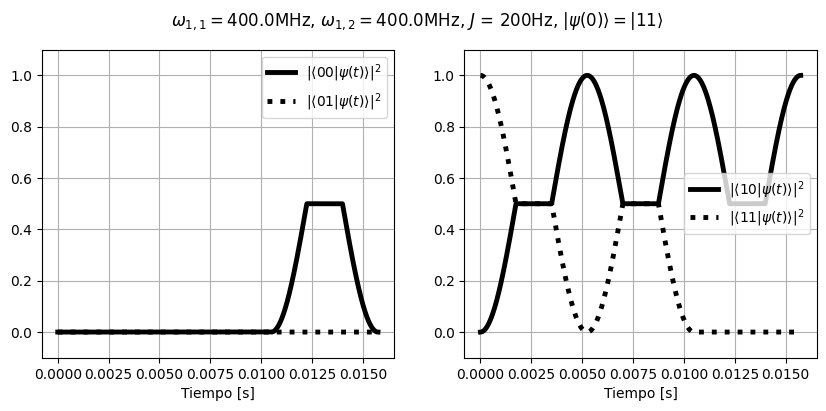

In [38]:
# Plotting the probabilities

t = np.linspace(delta_t[0][0], delta_t[-1][-1], STEP * 9)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

width = 3.5
color = 'black'

axes[0].plot(t, prob_00, color=color, linewidth=width, linestyle='-', label=r'$|\langle 00 | \psi (t) \rangle|^2$')
axes[0].plot(t, prob_01, color=color, linewidth=width, linestyle=':', label=r'$|\langle 01 | \psi (t) \rangle|^2$')

axes[0].grid()
axes[0].set_ylim([-0.1, 1.1])
axes[0].set_xlabel('Tiempo [s]')
#axes[0].set_ylabel(r'Probabilidad de medir al sistema en los estados')
axes[0].legend(loc='best', framealpha=0.8)

axes[1].plot(t, prob_10, color=color, linewidth=width, linestyle='-', label=r'$|\langle 10 | \psi (t) \rangle|^2$')
axes[1].plot(t, prob_11, color=color, linewidth=width, linestyle=':', label=r'$|\langle 11 | \psi (t) \rangle|^2$')

axes[1].grid()
axes[1].set_ylim([-0.1, 1.1])
axes[1].set_xlabel('Tiempo [s]')
axes[1].legend(loc='best', framealpha=0.8)

if psi_0 == state_00:
    init_cond = r'$| \psi (0) \rangle = | 00 \rangle$'
elif psi_0 == state_01:
    init_cond = r'$| \psi (0) \rangle = | 01 \rangle$'
elif psi_0 == state_10:
    init_cond = r'$| \psi (0) \rangle = | 10 \rangle$'
elif psi_0 == state_11:
    init_cond = r'$| \psi (0) \rangle = | 11 \rangle$'

text_0 = r'$\omega_{1, 1} = $' + f'{OMEGA_11 / 1000}MHz, '
text_1 = r'$\omega_{1, 2} = $' + f'{OMEGA_12 / 1000}MHz, '
text_3 = f'$J$ = {J}Hz, '
fig.suptitle(text_0 + text_1 + text_3 + init_cond)

plt.show()